In [4]:
import torch
import timeit
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [35]:
n_parameters = [1000, 10000, 100000, 1000000, 10000000]
batch_dims = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]
n_runs = 100
data = {
    'time': [],
    'n_parameters': [],
    'batch_dim': [],
    'run_idx': [],
}

for run_idx in range(n_runs):
    for n_params in n_parameters:
        for batch_dim in batch_dims:
            if batch_dim == 1:
                dim = int(n_params ** 0.5)
                input_tensor = torch.randn(dim, device='cuda')
                weight_tensor = torch.randn(dim, dim, device='cuda')
                data['time'].append(timeit.timeit(lambda: input_tensor @ weight_tensor, number=100))
            else:
                dim = int((n_params / batch_dim) ** 0.5)
                input_tensor = torch.randn(batch_dim, 1, dim, device='cuda')
                weight_tensor = torch.randn(batch_dim, dim, dim, device='cuda')
                data['time'].append(timeit.timeit(lambda: torch.bmm(input_tensor, weight_tensor), number=100))
            data['n_parameters'].append(n_params)
            data['batch_dim'].append(batch_dim)
            data['run_idx'].append(run_idx)

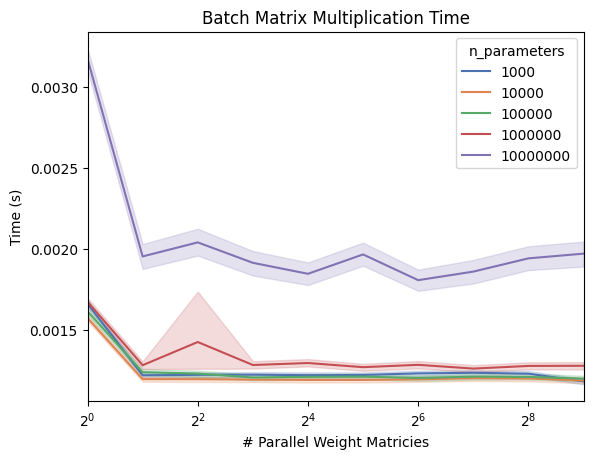

In [36]:
sns.lineplot(
    x = 'batch_dim',
    y = 'time',
    data = data,
    hue = 'n_parameters',
    palette = 'deep',
)

plt.title('Batch Matrix Multiplication Time')
plt.xlabel('# Parallel Weight Matricies')
plt.ylabel('Time (s)')

plt.xlim(min(batch_dims), max(batch_dims))

plt.xscale('log', base=2)
# plt.yscale('log')


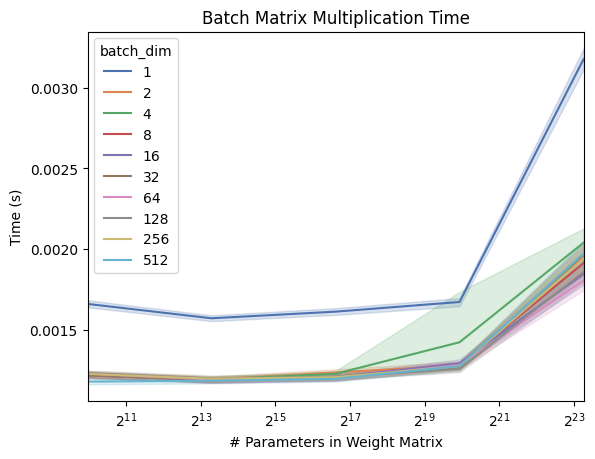

In [37]:
sns.lineplot(
    x = 'n_parameters',
    y = 'time',
    data = data,
    hue = 'batch_dim',
    palette = 'deep',
)

plt.title('Batch Matrix Multiplication Time')
plt.xlabel('# Parameters in Weight Matrix')
plt.ylabel('Time (s)')

plt.xlim(min(n_parameters), max(n_parameters))

plt.xscale('log', base=2)

# Conclusion

It looks like there is no downside to using sparsity if it is formatted in a way that can use PyTorch's BMM.
In fact, having at least 2 parallel computations seems to make a big difference over having only 1.
So long as the total number of FLOPs stays constant, CUDA seems just as fast when it comes to many small weight matricies as it is for a single large weight matrix.